In [21]:
import pandas as pd
import numpy as np
import matplotlib as plt
import glob

In [22]:
#get all filenames under the data directory
path = r'C:\Users\Patrycja\Python\2023 PROJECT ON GITHUB\SALES' 
l = [pd.read_csv(filename) for filename in glob.glob(path + "/*.csv")]

#check the number of files
print(len(l))

# create the dataset using all files under the data directory
df = pd.concat(l, axis=0)
df.head()

50


,sale_time,purchaser_gender
0,2012-10-01 01:42:22,female
1,2012-10-01 02:24:53,female
2,2012-10-01 02:25:40,female
3,2012-10-01 02:30:42,female
4,2012-10-01 02:51:32,male


Extract the sale day (year - month - day) from a complete timestamp we need to convert the column datatype to DateTime

In [23]:
sale_day = pd.to_datetime(df['sale_time'])

In [24]:
sale_day

0      2012-10-01 01:42:22
1      2012-10-01 02:24:53
2      2012-10-01 02:25:40
3      2012-10-01 02:30:42
4      2012-10-01 02:51:32
               ...        
4994   2013-09-15 23:30:51
4995   2013-09-15 23:42:02
4996   2013-09-15 23:43:24
4997   2013-09-15 23:43:32
4998   2013-09-15 23:48:47
Name: sale_time, Length: 204329, dtype: datetime64[ns]

Daily sales

In [25]:
daily_sales_df = sale_day.groupby(sale_day.dt.floor('d')).size().reset_index(name='sales_amount')

In [26]:
daily_sales_df

,sale_time,sales_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476
...,...,...
345,2013-09-11,719
346,2013-09-12,735
347,2013-09-13,743
348,2013-09-14,655


Plot daily sales

In [27]:
# assigh a constant figure size a
FIG_SIZE = (8,6)

In [28]:
daily_sales_df.index = daily_sales_df['sale_time']
daily_sales_df.drop(columns=['sale_time'], inplace=True)

In [29]:
daily_sales_df.head()

,sales_amount
sale_time,
2012-10-01,514
2012-10-02,482
2012-10-03,499
2012-10-04,546
2012-10-05,476


<AxesSubplot:title={'center':'Daily sales over 50 weeks'}, xlabel='sale_time'>

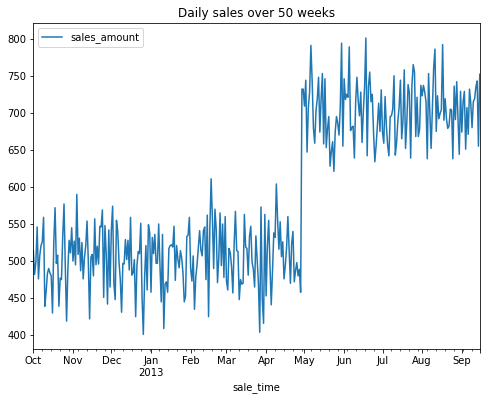

In [30]:
daily_sales_df.plot(figsize=FIG_SIZE, title = 'Daily sales over 50 weeks')

There has been a sudden change in daily sales. 

In [34]:
daily_sales_df['prev_day_sale_amount'] = [None] + daily_sales_df['sales_amount'].to_list()[:-1]
daily_sales_df['difference_btw_prev_day'] = daily_sales_df['sales_amount'] - daily_sales_df['prev_day_sale_amount']
daily_sales_df.head()

,sales_amount,prev_day_sale_amount,difference_btw_prev_day
sale_time,,,
2012-10-01,514,NaN,NaN
2012-10-02,482,514.0,-32.0
2012-10-03,499,482.0,17.0
2012-10-04,546,499.0,47.0
2012-10-05,476,546.0,-70.0


In [35]:
daily_sales_df.sort_values('difference_btw_prev_day', ascending=False)
daily_sales_df[daily_sales_df.index == '2013-04-29']

,sales_amount,prev_day_sale_amount,difference_btw_prev_day
sale_time,,,
2013-04-29,732,458.0,274.0


Determine if the change is statistically significant

In [28]:
#scipy.stats include a function to t-test and obtain p-value
from scipy import stats

#first drop all nan values (if any) for the test
daily_sales_df.dropna(inplace=True)

#compare the max change with all sales_amount  
stats.ttest_1samp(daily_sales_df['sales_amount'], 732)

Ttest_1sampResult(statistic=-26.273266340051002, pvalue=1.3019593251472396e-84)

Determine if change in daily sales is due to a shift in the proportion of male-vs-female customers

In [36]:
df.head()

,sale_time,purchaser_gender
0,2012-10-01 01:42:22,female
1,2012-10-01 02:24:53,female
2,2012-10-01 02:25:40,female
3,2012-10-01 02:30:42,female
4,2012-10-01 02:51:32,male


In [37]:
# create gender_portions_df 
df['sale_day'] = pd.to_datetime(df['sale_time']).dt.floor('d')
gender_portions_df = df.groupby(['sale_day','purchaser_gender']).size().reset_index(name='sales_amount')

In [38]:
gender_portions_df

,sale_day,purchaser_gender,sales_amount
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386
...,...,...,...
695,2013-09-13,male,537
696,2013-09-14,female,193
697,2013-09-14,male,462
698,2013-09-15,female,230


In [42]:
# calculate female and male sales amount separately
new_df = pd.DataFrame(gender_portions_df['sale_day'].unique(),columns=['sale_day'])
new_df['female_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'female']['sales_amount']).reset_index(drop=True)
new_df['male_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'male']['sales_amount']).reset_index(drop=True)
new_df[-5:]

,sale_day,female_sales_amount,male_sales_amount
345,2013-09-11,224,495
346,2013-09-12,225,510
347,2013-09-13,206,537
348,2013-09-14,193,462
349,2013-09-15,230,522


In [43]:
# calculate gender ratio of sales
new_df['gender_ratio'] = new_df['male_sales_amount']/new_df['female_sales_amount']

<AxesSubplot:title={'center':'Gender ratio and sales amount over all 50 weeks'}, xlabel='sale_day'>

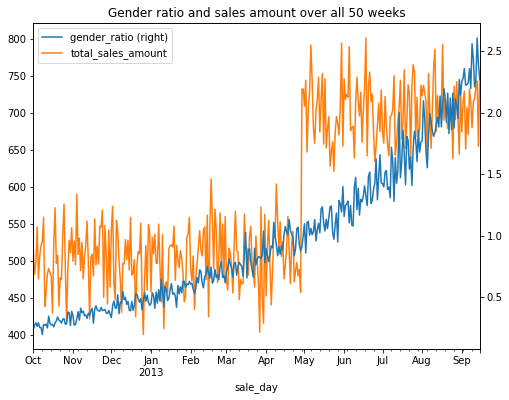

In [44]:
# plot gender ratio change over 50 weeks with the total sales amount
# observe if there is a correlation between them

plot_df = new_df.copy()
plot_df['total_sales_amount']  = plot_df['male_sales_amount'] + plot_df['female_sales_amount']
plot_df.drop(columns=['female_sales_amount', 'male_sales_amount'], inplace=True)
plot_df.index = plot_df['sale_day']
plot_df.drop(columns=['sale_day'], inplace=True)
plot_df.plot(secondary_y = ['gender_ratio'],figsize=FIG_SIZE, title= "Gender ratio and sales amount over all 50 weeks")

Percentage of sales in each daypart <br>
night (12:00AM - 6:00AM) <br>
morning (6:00AM to 12:00PM) <br>
afternoon (12:00PM to 6:00PM) <br>
evening (6:00PM - 12:00AM)

In [45]:
df.head()

,sale_time,purchaser_gender,sale_day
0,2012-10-01 01:42:22,female,2012-10-01
1,2012-10-01 02:24:53,female,2012-10-01
2,2012-10-01 02:25:40,female,2012-10-01
3,2012-10-01 02:30:42,female,2012-10-01
4,2012-10-01 02:51:32,male,2012-10-01


In [46]:
# extract sale hour to divide sales to the part of days
df['sale_hour']  = pd.to_datetime(df['sale_time']).dt.ceil('h').dt.hour
df.dtypes

sale_time                   object
purchaser_gender            object
sale_day            datetime64[ns]
sale_hour                    int64
dtype: object

In [47]:
def func(sale_hour):
    if sale_hour > 6 and sale_hour < 12:
        return "morning"
    if sale_hour > 12 and sale_hour < 18:
        return "afternoon"
    if sale_hour > 18 and sale_hour < 24:
        return "evening"
    if sale_hour >-1 and sale_hour < 6:
        return 'night'

In [48]:
df['part_day'] = df['sale_hour'].apply(func)

In [49]:
df.head()

,sale_time,purchaser_gender,sale_day,sale_hour,part_day
0,2012-10-01 01:42:22,female,2012-10-01,2,night
1,2012-10-01 02:24:53,female,2012-10-01,3,night
2,2012-10-01 02:25:40,female,2012-10-01,3,night
3,2012-10-01 02:30:42,female,2012-10-01,3,night
4,2012-10-01 02:51:32,male,2012-10-01,3,night


In [50]:
df.drop(columns= ['purchaser_gender', 'sale_hour', 'sale_time'], inplace= True)

In [53]:
# calculate sales amount per day part
df_pct_sales = df.groupby(df.part_day).size().reset_index(name='day_part_sales_amount')

# calculate sales amount percentage per day part
df_pct_sales['day_part_sales_percentage'] = df_pct_sales['day_part_sales_amount'] / df_pct_sales['day_part_sales_amount'].sum()

In [54]:
df_pct_sales

,part_day,day_part_sales_amount,day_part_sales_percentage
0,afternoon,68119,0.394595
1,evening,41111,0.238145
2,morning,49833,0.288669
3,night,13567,0.078590
